In [638]:
import os
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from supabase.client import create_client
import pymysql
import csv

# 1. Extraction Data

In [452]:
#csv files
df1 = pd.read_csv("electricity_access_percent.csv", usecols=lambda x: x != "Unnamed: 62", skiprows=4)
df2 = pd.read_csv("gdp_data.csv", usecols=lambda x: x != "Unnamed: 62", skiprows=4)
df3 = pd.read_csv("mystery.csv", usecols=lambda x: x != "Unnamed: 0", encoding="utf-16")
df4 = pd.read_csv("population_data.csv", usecols=lambda x: x != "Unnamed: 62", skiprows=4)
df5 = pd.read_csv("projects_data.csv")
df6 = pd.read_csv("rural_population_percent.csv", usecols=lambda x: x != "Unnamed: 62", skiprows=4)

C:\Users\Raihan\AppData\Local\Temp\ipykernel_2292\3224550627.py:6: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  df5 = pd.read_csv("projects_data.csv")


In [453]:
# json file
df7 = pd.read_json("population_data.json")

In [454]:
# xml files
with open("population_data.xml", "r") as f:
    xml_data = f.read()

soup = BeautifulSoup(xml_data, "lxml")

countries = []
items = []
years = []
values = []

for record in soup.find_all('record'):
    country = record.find("field", {"name": "Country or Area"}).text
    item = record.find("field", {"name": "Item"}).text

    year_tag = record.find("field", {"name": "Year"})
    year = int(year_tag.text) if year_tag.text else None
    
    value_tag = record.find("field", {"name": "Value"})
    value = int(value_tag.text) if value_tag.text else None

    countries.append(country)
    items.append(item)
    years.append(year)
    values.append(value)

data = {
    "Country": countries,
    "Item": items,
    "Year": years,
    "Value": values
}

df8 = pd.DataFrame(data)

In [455]:
# SQL file
data = []

conn = sqlite3.connect('population_data.db')

df9 = pd.read_sql_query(f'SELECT * FROM population_data', conn)

conn.close()

df9.drop('index', axis=1, inplace=True)

In [456]:
# API
url = 'https://api.worldbank.org/v2/countries/all/indicators/SP.POP.TOTL/?format=json&date=2018:2022&per_page=15312'

response = requests.get(url)
data = response.json()[1]

data_list = []

for item in data:
    country_code = item["countryiso3code"]
    country = item["country"]["value"]
    indicator = item["indicator"]["id"]
    indicator_name = item["indicator"]["value"]
    value = item["value"]
    date = item["date"]

    data_list.append({
        "Country Code": country_code,
        "Country Name": country,
        "Indicator Code": indicator,
        "Indicator Name": indicator_name,
        "Value": value,
        "Year": date,
    })

df10 = pd.DataFrame(data_list)

### Data Tambahan

##### Data tambahan untuk gdp

In [457]:
url = 'https://api.worldbank.org/v2/countries/all/indicators/NY.GDP.MKTP.CD/?format=json&date=2018:2022&per_page=15312'

response = requests.get(url)
data = response.json()[1]

data_list_gdp = []

for item in data:
    country_code = item["countryiso3code"]
    country = item["country"]["value"]
    indicator = item["indicator"]["id"]
    indicator_name = item["indicator"]["value"]
    value = item["value"]
    date = item["date"]

    data_list_gdp.append({
        "Country Name": country,
        "Country Code": country_code,
        "Indicator Name": indicator_name,
        "Indicator Code": indicator,
        "Year": date,
        "GDP": value,
    })

df11 = pd.DataFrame(data_list_gdp)

In [458]:
cek = df11[df11['Country Name'] == 'Zimbabwe']
cek

,Country Name,Country Code,Indicator Name,Indicator Code,Year,GDP
1325,Zimbabwe,ZWE,GDP (current US$),NY.GDP.MKTP.CD,2022,2.736663e+10
1326,Zimbabwe,ZWE,GDP (current US$),NY.GDP.MKTP.CD,2021,2.837124e+10
1327,Zimbabwe,ZWE,GDP (current US$),NY.GDP.MKTP.CD,2020,2.150970e+10
1328,Zimbabwe,ZWE,GDP (current US$),NY.GDP.MKTP.CD,2019,2.183223e+10
1329,Zimbabwe,ZWE,GDP (current US$),NY.GDP.MKTP.CD,2018,3.415607e+10


##### Data Tambahan untuk electricity

In [459]:
url = 'https://api.worldbank.org/v2/countries/all/indicators/EG.ELC.ACCS.ZS/?format=json&date=2018:2023&per_page=15312'

response = requests.get(url)
data = response.json()[1]

data_list_electricity = []

for item in data:
    country_code = item["countryiso3code"]
    country = item["country"]["value"]
    indicator = item["indicator"]["id"]
    indicator_name = item["indicator"]["value"]
    value = item["value"]
    date = item["date"]

    data_list_electricity.append({
        "Country Name": country,
        "Country Code": country_code,
        "Indicator Name": indicator_name,
        "Indicator Code": indicator,
        "Year": date,
        "electricityaccesspercent": value,
    })

df12 = pd.DataFrame(data_list_electricity)

#### Data Tambahan untuk rural population

In [460]:
url = 'https://api.worldbank.org/v2/countries/all/indicators/SP.RUR.TOTL.ZS/?format=json&date=2018:2023&per_page=15312'

response = requests.get(url)
data = response.json()[1]

data_list_electricity = []

for item in data:
    country_code = item["countryiso3code"]
    country = item["country"]["value"]
    indicator = item["indicator"]["id"]
    indicator_name = item["indicator"]["value"]
    value = item["value"]
    date = item["date"]

    data_list_electricity.append({
        "Country Name": country,
        "Country Code": country_code,
        "Indicator Name": indicator_name,
        "Indicator Code": indicator,
        "Year": date,
        "ruralpopulationpercent": value,
    })

df13 = pd.DataFrame(data_list_electricity)

### 1.1 datatype, missing value and duplicate check

In [461]:
dataframe = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]

for df in dataframe:
    print("\nData Type : ")
    print(df.dtypes)

    print("\nMissing Value : ")
    print(df.isnull().sum())
    
    print("\nDuplicates : ", df.duplicated().sum())

    display(df.head()) 


Data Type : 
Country Name       object
Country Code       object
Indicator Name     object
Indicator Code     object
1960              float64
                   ...   
2013              float64
2014              float64
2015              float64
2016              float64
2017              float64
Length: 62, dtype: object

Missing Value : 
Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
1960              264
                 ... 
2013                3
2014                3
2015                3
2016                3
2017              264
Length: 62, dtype: int64

Duplicates :  0


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,93.086166,93.354546,93.356292,93.942375,94.255814,94.578262,94.906723,95.238182,95.570145,NaN
1,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,42.400000,44.854885,42.700000,43.222019,69.100000,67.259552,89.500000,71.500000,84.137138,NaN
2,Angola,AGO,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,31.268013,32.382469,33.514950,34.600000,35.821964,36.990490,32.000000,42.000000,40.520607,NaN
3,Albania,ALB,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN
4,Andorra,AND,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN



Data Type : 
Country Name       object
Country Code       object
Indicator Name     object
Indicator Code     object
1960              float64
                   ...   
2013              float64
2014              float64
2015              float64
2016              float64
2017              float64
Length: 62, dtype: object

Missing Value : 
Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
1960              140
                 ... 
2013               16
2014               17
2015               18
2016               23
2017               30
Length: 62, dtype: int64

Duplicates :  0


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.791961e+09,2.498933e+09,2.467704e+09,2.584464e+09,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,1.019053e+10,1.248694e+10,1.593680e+10,1.793024e+10,2.053654e+10,2.026425e+10,2.061610e+10,1.921556e+10,1.946902e+10,2.081530e+10
2,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,8.417804e+10,7.549239e+10,8.252614e+10,1.041158e+11,1.139232e+11,1.249125e+11,1.267302e+11,1.026212e+11,9.533720e+10,1.242094e+11
3,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.288135e+10,1.204421e+10,1.192695e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.138693e+10,1.188368e+10,1.303935e+10
4,Andorra,AND,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4.007353e+09,3.660531e+09,3.355695e+09,3.442063e+09,3.164615e+09,3.281585e+09,3.350736e+09,2.811489e+09,2.877312e+09,3.012914e+09



Data Type : 
Country Name       object
Country Code       object
Indicator Name     object
Indicator Code     object
1960              float64
                   ...   
2013              float64
2014              float64
2015              float64
2016              float64
2017              float64
Length: 62, dtype: object

Missing Value : 
Country Name      0
Country Code      0
Indicator Name    0
Indicator Code    0
1960              4
                 ..
2013              2
2014              2
2015              2
2016              2
2017              2
Length: 62, dtype: int64

Duplicates :  0


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0



Data Type : 
Country Name       object
Country Code       object
Indicator Name     object
Indicator Code     object
1960              float64
                   ...   
2013              float64
2014              float64
2015              float64
2016              float64
2017              float64
Length: 62, dtype: object

Missing Value : 
Country Name      0
Country Code      0
Indicator Name    0
Indicator Code    0
1960              4
                 ..
2013              2
2014              2
2015              2
2016              2
2017              2
Length: 62, dtype: int64

Duplicates :  0


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0



Data Type : 
id                           object
regionname                   object
countryname                  object
prodline                     object
lendinginstr                 object
lendinginstrtype             object
envassesmentcategorycode     object
supplementprojectflg         object
productlinetype              object
projectstatusdisplay         object
status                       object
project_name                 object
boardapprovaldate            object
board_approval_month         object
closingdate                  object
lendprojectcost              object
ibrdcommamt                  object
idacommamt                   object
totalamt                     object
grantamt                     object
borrower                     object
impagency                    object
url                          object
projectdoc                  float64
majorsector_percent         float64
sector1                      object
sector2                      object
sector3       

,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,envassesmentcategorycode,supplementprojectflg,productlinetype,projectstatusdisplay,...,mjtheme3name,mjtheme4name,mjtheme5name,location,GeoLocID,GeoLocName,Latitude,Longitude,Country,Unnamed: 56
0,P162228,Other,World;World,RE,Investment Project Financing,IN,C,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P163962,Africa,Democratic Republic of the Congo;Democratic Re...,PE,Investment Project Financing,IN,B,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P167672,South Asia,People's Republic of Bangladesh;People's Repub...,PE,Investment Project Financing,IN,NaN,Y,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P158768,South Asia,Islamic Republic of Afghanistan;Islamic Repu...,PE,Investment Project Financing,IN,A,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P161364,Africa,Federal Republic of Nigeria;Federal Republic o...,PE,Investment Project Financing,IN,B,N,L,Active,...,NaN,NaN,NaN,0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...,0002327546;0002328925;0002565340;0002565343;00...,Ogun State;Niger State;Abia State;Edo;Kebbi St...,7;10;5.41667;6.5;11.5;8,3.58333;6;7.5;6;4;10.5,NG;NG;NG;NG;NG;NG,NaN



Data Type : 
Country Name       object
Country Code       object
Indicator Name     object
Indicator Code     object
1960              float64
                   ...   
2013              float64
2014              float64
2015              float64
2016              float64
2017              float64
Length: 62, dtype: object

Missing Value : 
Country Name      0
Country Code      0
Indicator Name    0
Indicator Code    0
1960              5
                 ..
2013              4
2014              4
2015              4
2016              4
2017              4
Length: 62, dtype: int64

Duplicates :  0


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,Rural population (% of total population),SP.RUR.TOTL.ZS,49.224,49.239,49.254,49.270,49.285,49.300,...,56.217,56.579,56.941,57.302,57.636,57.942,58.221,58.472,58.696,58.893
1,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,91.779,91.492,91.195,90.890,90.574,90.250,...,76.054,75.687,75.311,74.926,74.532,74.129,73.718,73.297,72.868,72.430
2,Angola,AGO,Rural population (% of total population),SP.RUR.TOTL.ZS,89.565,89.202,88.796,88.376,87.942,87.496,...,61.491,60.701,59.903,59.100,58.301,57.510,56.726,55.950,55.181,54.422
3,Albania,ALB,Rural population (% of total population),SP.RUR.TOTL.ZS,69.295,69.057,68.985,68.914,68.842,68.770,...,50.009,48.924,47.837,46.753,45.670,44.617,43.591,42.593,41.624,40.684
4,Andorra,AND,Rural population (% of total population),SP.RUR.TOTL.ZS,41.550,39.017,36.538,34.128,31.795,29.555,...,11.133,11.648,12.183,12.740,13.292,13.835,14.367,14.885,15.388,15.873



Data Type : 
Country Name       object
Country Code       object
Indicator Name     object
Indicator Code     object
1960              float64
                   ...   
2013              float64
2014              float64
2015              float64
2016              float64
2017              float64
Length: 62, dtype: object

Missing Value : 
Country Name      0
Country Code      0
Indicator Name    0
Indicator Code    0
1960              4
                 ..
2013              2
2014              2
2015              2
2016              2
2017              2
Length: 62, dtype: int64

Duplicates :  0


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0



Data Type : 
Country     object
Item        object
Year         int64
Value      float64
dtype: object

Missing Value : 
Country      0
Item         0
Year         0
Value      165
dtype: int64

Duplicates :  0


,Country,Item,Year,Value
0,Aruba,"Population, total",1960,54211.0
1,Aruba,"Population, total",1961,55438.0
2,Aruba,"Population, total",1962,56225.0
3,Aruba,"Population, total",1963,56695.0
4,Aruba,"Population, total",1964,57032.0



Data Type : 
Country_Name       object
Country_Code       object
Indicator_Name     object
Indicator_Code     object
1960              float64
                   ...   
2013              float64
2014              float64
2015              float64
2016              float64
2017              float64
Length: 62, dtype: object

Missing Value : 
Country_Name      0
Country_Code      0
Indicator_Name    0
Indicator_Code    0
1960              4
                 ..
2013              2
2014              2
2015              2
2016              2
2017              2
Length: 62, dtype: int64

Duplicates :  0


,Country_Name,Country_Code,Indicator_Name,Indicator_Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0



Data Type : 
Country Code       object
Country Name       object
Indicator Code     object
Indicator Name     object
Value             float64
Year               object
dtype: object

Missing Value : 
Country Code      0
Country Name      0
Indicator Code    0
Indicator Name    0
Value             5
Year              0
dtype: int64

Duplicates :  0


,Country Code,Country Name,Indicator Code,Indicator Name,Value,Year
0,AFE,Africa Eastern and Southern,SP.POP.TOTL,"Population, total",720859132.0,2022
1,AFE,Africa Eastern and Southern,SP.POP.TOTL,"Population, total",702977106.0,2021
2,AFE,Africa Eastern and Southern,SP.POP.TOTL,"Population, total",685112979.0,2020
3,AFE,Africa Eastern and Southern,SP.POP.TOTL,"Population, total",667242986.0,2019
4,AFE,Africa Eastern and Southern,SP.POP.TOTL,"Population, total",649757148.0,2018


# 2. Transform Data

List of DataFrames
- df1 = electricity_access_percent.csv
- df2 = gdp_data.csv
- df3 = mystery.csv
- df4 = population_data.csv
- df5 = projects_data.csv
- df6 = rural_population_percent.csv
- df7 = population_data.json
- df8 = population_data.xml
- df9 = pouplation_data.db
- df10 = API World Bank

### 2.1 Combine Data

##### Combine data rural_population_percent.csv dan electricity_access_percent.csv

In [462]:
df1 = pd.melt(df1, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                    var_name='Year', value_name='electricityaccesspercent')

df6 = pd.melt(df6, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                    var_name='Year', value_name='ruralpopulationpercent')

In [463]:
electricity_df = pd.concat([df1, df12], ignore_index=True)
electricity_df = electricity_df.sort_values(by='Year')

In [464]:
rural_population_df = pd.concat([df6, df13], ignore_index=True)
rural_population_df = rural_population_df.sort_values(by='Year')

In [465]:
combined = pd.merge(electricity_df, rural_population_df, on=['Country Name', 'Country Code', 'Year'], how='inner')
combined

,Country Name,Country Code,Indicator Name_x,Indicator Code_x,Year,electricityaccesspercent,Indicator Name_y,Indicator Code_y,ruralpopulationpercent
0,Aruba,ABW,Access to electricity (% of population),EG.ELC.ACCS.ZS,1960,NaN,Rural population (% of total population),SP.RUR.TOTL.ZS,49.224000
1,Malaysia,MYS,Access to electricity (% of population),EG.ELC.ACCS.ZS,1960,NaN,Rural population (% of total population),SP.RUR.TOTL.ZS,73.402000
2,North America,NAC,Access to electricity (% of population),EG.ELC.ACCS.ZS,1960,NaN,Rural population (% of total population),SP.RUR.TOTL.ZS,30.081597
3,Namibia,NAM,Access to electricity (% of population),EG.ELC.ACCS.ZS,1960,NaN,Rural population (% of total population),SP.RUR.TOTL.ZS,82.091000
4,New Caledonia,NCL,Access to electricity (% of population),EG.ELC.ACCS.ZS,1960,NaN,Rural population (% of total population),SP.RUR.TOTL.ZS,62.640000
...,...,...,...,...,...,...,...,...,...
16903,Liberia,LBR,Access to electricity (% of population),EG.ELC.ACCS.ZS,2023,NaN,Rural population (% of total population),SP.RUR.TOTL.ZS,NaN
16904,Lesotho,LSO,Access to electricity (% of population),EG.ELC.ACCS.ZS,2023,NaN,Rural population (% of total population),SP.RUR.TOTL.ZS,NaN
16905,Lebanon,LBN,Access to electricity (% of population),EG.ELC.ACCS.ZS,2023,NaN,Rural population (% of total population),SP.RUR.TOTL.ZS,NaN
16906,Malawi,MWI,Access to electricity (% of population),EG.ELC.ACCS.ZS,2023,NaN,Rural population (% of total population),SP.RUR.TOTL.ZS,NaN


##### Combine Population Data

In [466]:
df9.rename(columns={'Country_Name': 'Country Name',
                    'Country_Code': 'Country Code',
                    'Indicator_Name': 'Indicator Name',
                    'Indicator_Code': 'Indicator Code' 
                    }, inplace=True)

In [467]:
df3 = pd.melt(df3, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                    var_name='Year', value_name='Value')

df4 = pd.melt(df4, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                    var_name='Year', value_name='Value')

df7 = pd.melt(df7, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                    var_name='Year', value_name='Value')

df9 = pd.melt(df9, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                    var_name='Year', value_name='Value')

In [468]:
df8.rename(columns={'Country': 'Country Name', 'Item': 'Indicator Name'}, inplace=True)

In [469]:
population_data = [df3, df4, df7, df8, df9]

population_df = population_data[0]

for data in population_data[1:]:
    population_df = population_df.combine_first(data)

population_df


,Country Code,Country Name,Indicator Code,Indicator Name,Value,Year
0,ABW,Aruba,SP.POP.TOTL,"Population, total",54211.0,1960
1,AFG,Afghanistan,SP.POP.TOTL,"Population, total",8996351.0,1960
2,AGO,Angola,SP.POP.TOTL,"Population, total",5643182.0,1960
3,ALB,Albania,SP.POP.TOTL,"Population, total",1608800.0,1960
4,AND,Andorra,SP.POP.TOTL,"Population, total",13411.0,1960
...,...,...,...,...,...,...
15307,XKX,Kosovo,SP.POP.TOTL,"Population, total",1830700.0,2017
15308,YEM,"Yemen, Rep.",SP.POP.TOTL,"Population, total",28250420.0,2017
15309,ZAF,South Africa,SP.POP.TOTL,"Population, total",56717156.0,2017
15310,ZMB,Zambia,SP.POP.TOTL,"Population, total",17094130.0,2017


In [470]:
population_df = pd.concat([population_df, df10])
population_df = population_df.sort_values(by='Year')
population_df

,Country Code,Country Name,Indicator Code,Indicator Name,Value,Year
0,ABW,Aruba,SP.POP.TOTL,"Population, total",5.421100e+04,1960
167,MYS,Malaysia,SP.POP.TOTL,"Population, total",8.157106e+06,1960
168,NAC,North America,SP.POP.TOTL,"Population, total",1.986244e+08,1960
169,NAM,Namibia,SP.POP.TOTL,"Population, total",6.025440e+05,1960
170,NCL,New Caledonia,SP.POP.TOTL,"Population, total",7.900000e+04,1960
...,...,...,...,...,...,...
795,LBN,Lebanon,SP.POP.TOTL,"Population, total",5.489739e+06,2022
105,IDA,IDA total,SP.POP.TOTL,"Population, total",1.840143e+09,2022
790,LVA,Latvia,SP.POP.TOTL,"Population, total",1.879383e+06,2022
780,KGZ,Kyrgyz Republic,SP.POP.TOTL,"Population, total",6.974900e+06,2022


#### Combine GDP data

In [471]:
df2 = pd.melt(df2, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                    var_name='Year', value_name='GDP')

In [472]:
gdp_df = pd.concat([df2, df11], ignore_index=True)
gdp_df = gdp_df.sort_values(by='Year')

In [473]:
gdp_df

,Country Name,Country Code,Indicator Name,Indicator Code,Year,GDP
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,1960,NaN
167,Malaysia,MYS,GDP (current US$),NY.GDP.MKTP.CD,1960,1.916242e+09
168,North America,NAC,GDP (current US$),NY.GDP.MKTP.CD,1960,5.844779e+11
169,Namibia,NAM,GDP (current US$),NY.GDP.MKTP.CD,1960,NaN
170,New Caledonia,NCL,GDP (current US$),NY.GDP.MKTP.CD,1960,NaN
...,...,...,...,...,...,...
16107,Lebanon,LBN,GDP (current US$),NY.GDP.MKTP.CD,2022,NaN
15417,IDA total,IDA,GDP (current US$),NY.GDP.MKTP.CD,2022,2.822822e+12
16102,Latvia,LVA,GDP (current US$),NY.GDP.MKTP.CD,2022,4.093203e+10
16092,Kyrgyz Republic,KGZ,GDP (current US$),NY.GDP.MKTP.CD,2022,1.154397e+10


### 2.2 Cleaning Data

In [474]:
def cleanse_data(df):
    df = df.fillna(0)
    df = df.drop_duplicates()
    df = df.loc[:,~df.columns.duplicated()]
    return df

population_df = cleanse_data(population_df)
combined = cleanse_data(combined)
gdp_df = cleanse_data(gdp_df)

### 2.3 Adjusting DataType

##### projects_data.csv

In [475]:
print(df5.dtypes)

id                           object
regionname                   object
countryname                  object
prodline                     object
lendinginstr                 object
lendinginstrtype             object
envassesmentcategorycode     object
supplementprojectflg         object
productlinetype              object
projectstatusdisplay         object
status                       object
project_name                 object
boardapprovaldate            object
board_approval_month         object
closingdate                  object
lendprojectcost              object
ibrdcommamt                  object
idacommamt                   object
totalamt                     object
grantamt                     object
borrower                     object
impagency                    object
url                          object
projectdoc                  float64
majorsector_percent         float64
sector1                      object
sector2                      object
sector3                     

In [476]:
df5[['boardapprovaldate', 'closingdate']] = df5[['boardapprovaldate', 'closingdate']].apply(pd.to_datetime, format='%Y-%m-%dT%H:%M:%SZ')

columns_to_replace = ['lendprojectcost', 'ibrdcommamt', 'idacommamt', 'totalamt', 'grantamt']
df5[columns_to_replace] = df5[columns_to_replace].apply(lambda x: x.str.replace(',', ''))

df5[columns_to_replace] = df5[columns_to_replace].apply(pd.to_numeric)

In [477]:
print(df5.dtypes)

id                                  object
regionname                          object
countryname                         object
prodline                            object
lendinginstr                        object
lendinginstrtype                    object
envassesmentcategorycode            object
supplementprojectflg                object
productlinetype                     object
projectstatusdisplay                object
status                              object
project_name                        object
boardapprovaldate           datetime64[ns]
board_approval_month                object
closingdate                 datetime64[ns]
lendprojectcost                    float64
ibrdcommamt                          int64
idacommamt                           int64
totalamt                             int64
grantamt                             int64
borrower                            object
impagency                           object
url                                 object
projectdoc 

##### Population Data

In [478]:
print(population_df.dtypes)

Country Code       object
Country Name       object
Indicator Code     object
Indicator Name     object
Value             float64
Year               object
dtype: object


Value sudah bernilai float, sehingga tidak perlu diubah lagi

##### Kombinasi data rural dan electricity

In [479]:
combined['Year'] = combined['Year'].astype(int)

##### GDP Data

In [480]:
gdp_df['Year'] = gdp_df['Year'].astype(int)

### 2.4 Get Dummy

##### projects_data.csv

In [481]:
dummy_projects_data = pd.get_dummies(df5, prefix=['prodline',
                            'lendinginstrtype',
                            'envassesmentcategorycode',
                            'supplementprojectflg',
                            'productlinetype',
                            'projectstatusdisplay'],
                            columns=['prodline',
                                    'lendinginstrtype',
                                    'envassesmentcategorycode',
                                    'supplementprojectflg',
                                    'productlinetype',
                                    'projectstatusdisplay'])

In [482]:
df5.drop(columns=['prodline',
                  'lendinginstrtype',
                  'envassesmentcategorycode',
                  'supplementprojectflg',
                  'productlinetype',
                  'projectstatusdisplay'], inplace=True)

df5 = pd.concat([df5, dummy_projects_data], axis=1)

In [483]:
df5

,id,regionname,countryname,lendinginstr,status,project_name,boardapprovaldate,board_approval_month,closingdate,lendprojectcost,...,envassesmentcategorycode_D,envassesmentcategorycode_F,envassesmentcategorycode_U,supplementprojectflg_N,supplementprojectflg_Y,productlinetype_L,projectstatusdisplay_Active,projectstatusdisplay_Closed,projectstatusdisplay_Dropped,projectstatusdisplay_Pipeline
0,P162228,Other,World;World,Investment Project Financing,Active,Creating a Trade in Value-Added Database for ...,2018-06-28,June,NaT,500000.0,...,False,False,False,True,False,True,True,False,False,False
1,P163962,Africa,Democratic Republic of the Congo;Democratic Re...,Investment Project Financing,Active,Productive Inclusion Project,2018-06-28,June,2023-12-31,200000000.0,...,False,False,False,True,False,True,True,False,False,False
2,P167672,South Asia,People's Republic of Bangladesh;People's Repub...,Investment Project Financing,Active,Additional Financing for Health Sector Support...,2018-06-28,June,NaT,50000000.0,...,False,False,False,False,True,True,True,False,False,False
3,P158768,South Asia,Islamic Republic of Afghanistan;Islamic Repu...,Investment Project Financing,Active,Public-Private Partnerships and Public Investm...,2018-06-27,June,2023-06-28,50000000.0,...,False,False,False,True,False,True,True,False,False,False
4,P161364,Africa,Federal Republic of Nigeria;Federal Republic o...,Investment Project Financing,Active,Nigeria For Women Project,2018-06-27,June,2023-05-31,100000000.0,...,False,False,False,True,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,P006578,Latin America and Caribbean,Republic of Chile;Republic of Chile,Specific Investment Loan,Closed,Power and Irrigation Project,1948-03-25,March,1954-12-31,13500000.0,...,False,False,False,True,False,True,False,True,False,False
18244,P037451,Europe and Central Asia,Grand Duchy of Luxembourg;Grand Duchy of Luxem...,Structural Adjustment Loan,Closed,Steel Mill and Railway Project,1947-08-28,August,1949-03-31,12000000.0,...,False,False,False,True,False,True,False,True,False,False
18245,P037362,Europe and Central Asia,Kingdom of Denmark;Kingdom of Denmark,Structural Adjustment Loan,Closed,Post War Reconstruction Project,1947-08-22,August,1949-03-31,40000000.0,...,False,False,False,True,False,True,False,True,False,False
18246,P037452,Europe and Central Asia,Kingdom of the Netherlands;Kingdom of the Neth...,Structural Adjustment Loan,Closed,Post-war Reconstruction Project,1947-08-07,August,1948-06-30,195000000.0,...,False,False,False,True,False,True,False,True,False,False


### 2.5 Imputing Data 

##### Imputing Data pada gdp_data.csv

In [484]:
gdp_df

,Country Name,Country Code,Indicator Name,Indicator Code,Year,GDP
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,1960,0.000000e+00
167,Malaysia,MYS,GDP (current US$),NY.GDP.MKTP.CD,1960,1.916242e+09
168,North America,NAC,GDP (current US$),NY.GDP.MKTP.CD,1960,5.844779e+11
169,Namibia,NAM,GDP (current US$),NY.GDP.MKTP.CD,1960,0.000000e+00
170,New Caledonia,NCL,GDP (current US$),NY.GDP.MKTP.CD,1960,0.000000e+00
...,...,...,...,...,...,...
16107,Lebanon,LBN,GDP (current US$),NY.GDP.MKTP.CD,2022,0.000000e+00
15417,IDA total,IDA,GDP (current US$),NY.GDP.MKTP.CD,2022,2.822822e+12
16102,Latvia,LVA,GDP (current US$),NY.GDP.MKTP.CD,2022,4.093203e+10
16092,Kyrgyz Republic,KGZ,GDP (current US$),NY.GDP.MKTP.CD,2022,1.154397e+10


In [485]:
gdp_df.ffill(inplace=True)
gdp_df.bfill(inplace=True)

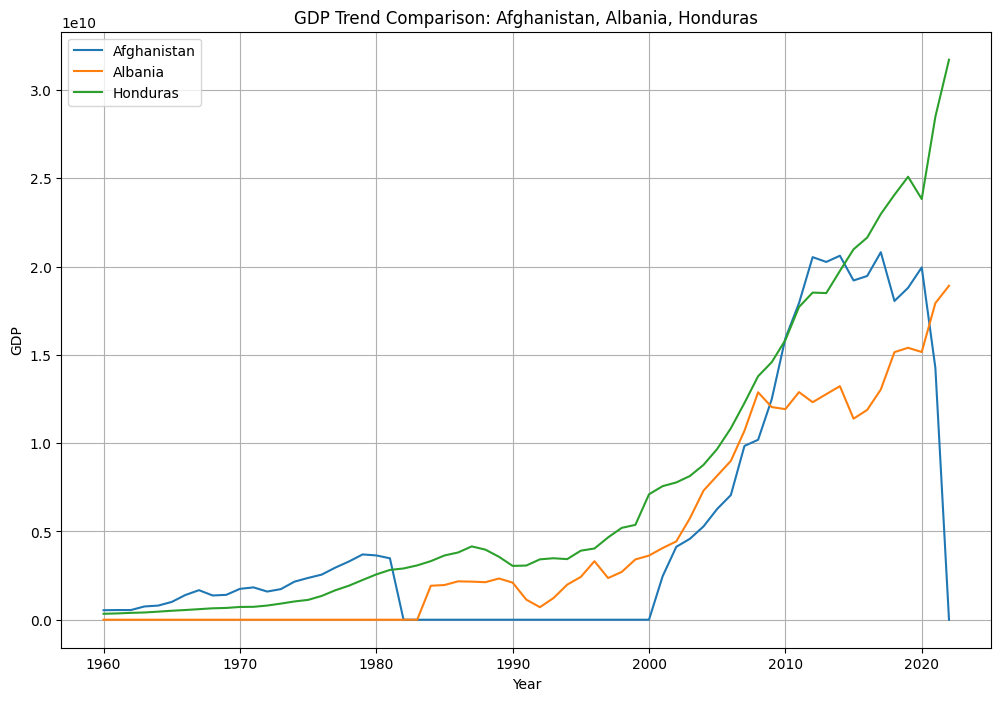

In [486]:
import pandas as pd
import matplotlib.pyplot as plt

country1 = 'Afghanistan'  
country2 = 'Albania'
country3 = 'Honduras' 

country1_data = gdp_df[gdp_df['Country Name'] == country1]
country2_data = gdp_df[gdp_df['Country Name'] == country2]
country3_data = gdp_df[gdp_df['Country Name'] == country3]

# Create line charts for each country
plt.figure(figsize=(12, 8))
plt.plot(country1_data['Year'].values, country1_data['GDP'].values, label=country1)
plt.plot(country2_data['Year'].values, country2_data['GDP'].values, label=country2)
plt.plot(country3_data['Year'].values, country3_data['GDP'].values, label=country3)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('GDP')
plt.title('GDP Trend Comparison: {}, {}, {}'.format(country1, country2, country3))
plt.legend()

# Show plot
plt.grid(True)
plt.show()

### 2.6 Replace and Regex

##### Projects_data.csv

In [487]:
df5

,id,regionname,countryname,lendinginstr,status,project_name,boardapprovaldate,board_approval_month,closingdate,lendprojectcost,...,envassesmentcategorycode_D,envassesmentcategorycode_F,envassesmentcategorycode_U,supplementprojectflg_N,supplementprojectflg_Y,productlinetype_L,projectstatusdisplay_Active,projectstatusdisplay_Closed,projectstatusdisplay_Dropped,projectstatusdisplay_Pipeline
0,P162228,Other,World;World,Investment Project Financing,Active,Creating a Trade in Value-Added Database for ...,2018-06-28,June,NaT,500000.0,...,False,False,False,True,False,True,True,False,False,False
1,P163962,Africa,Democratic Republic of the Congo;Democratic Re...,Investment Project Financing,Active,Productive Inclusion Project,2018-06-28,June,2023-12-31,200000000.0,...,False,False,False,True,False,True,True,False,False,False
2,P167672,South Asia,People's Republic of Bangladesh;People's Repub...,Investment Project Financing,Active,Additional Financing for Health Sector Support...,2018-06-28,June,NaT,50000000.0,...,False,False,False,False,True,True,True,False,False,False
3,P158768,South Asia,Islamic Republic of Afghanistan;Islamic Repu...,Investment Project Financing,Active,Public-Private Partnerships and Public Investm...,2018-06-27,June,2023-06-28,50000000.0,...,False,False,False,True,False,True,True,False,False,False
4,P161364,Africa,Federal Republic of Nigeria;Federal Republic o...,Investment Project Financing,Active,Nigeria For Women Project,2018-06-27,June,2023-05-31,100000000.0,...,False,False,False,True,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,P006578,Latin America and Caribbean,Republic of Chile;Republic of Chile,Specific Investment Loan,Closed,Power and Irrigation Project,1948-03-25,March,1954-12-31,13500000.0,...,False,False,False,True,False,True,False,True,False,False
18244,P037451,Europe and Central Asia,Grand Duchy of Luxembourg;Grand Duchy of Luxem...,Structural Adjustment Loan,Closed,Steel Mill and Railway Project,1947-08-28,August,1949-03-31,12000000.0,...,False,False,False,True,False,True,False,True,False,False
18245,P037362,Europe and Central Asia,Kingdom of Denmark;Kingdom of Denmark,Structural Adjustment Loan,Closed,Post War Reconstruction Project,1947-08-22,August,1949-03-31,40000000.0,...,False,False,False,True,False,True,False,True,False,False
18246,P037452,Europe and Central Asia,Kingdom of the Netherlands;Kingdom of the Neth...,Structural Adjustment Loan,Closed,Post-war Reconstruction Project,1947-08-07,August,1948-06-30,195000000.0,...,False,False,False,True,False,True,False,True,False,False


In [488]:
df5 = df5.replace(to_replace=r'\b(.+?)(?:;\1\b)+', regex=True, value=r'\1')

In [489]:
df5

,id,regionname,countryname,lendinginstr,status,project_name,boardapprovaldate,board_approval_month,closingdate,lendprojectcost,...,envassesmentcategorycode_D,envassesmentcategorycode_F,envassesmentcategorycode_U,supplementprojectflg_N,supplementprojectflg_Y,productlinetype_L,projectstatusdisplay_Active,projectstatusdisplay_Closed,projectstatusdisplay_Dropped,projectstatusdisplay_Pipeline
0,P162228,Other,World,Investment Project Financing,Active,Creating a Trade in Value-Added Database for ...,2018-06-28,June,NaT,500000.0,...,False,False,False,True,False,True,True,False,False,False
1,P163962,Africa,Democratic Republic of the Congo,Investment Project Financing,Active,Productive Inclusion Project,2018-06-28,June,2023-12-31,200000000.0,...,False,False,False,True,False,True,True,False,False,False
2,P167672,South Asia,People's Republic of Bangladesh,Investment Project Financing,Active,Additional Financing for Health Sector Support...,2018-06-28,June,NaT,50000000.0,...,False,False,False,False,True,True,True,False,False,False
3,P158768,South Asia,Islamic Republic of Afghanistan,Investment Project Financing,Active,Public-Private Partnerships and Public Investm...,2018-06-27,June,2023-06-28,50000000.0,...,False,False,False,True,False,True,True,False,False,False
4,P161364,Africa,Federal Republic of Nigeria,Investment Project Financing,Active,Nigeria For Women Project,2018-06-27,June,2023-05-31,100000000.0,...,False,False,False,True,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,P006578,Latin America and Caribbean,Republic of Chile,Specific Investment Loan,Closed,Power and Irrigation Project,1948-03-25,March,1954-12-31,13500000.0,...,False,False,False,True,False,True,False,True,False,False
18244,P037451,Europe and Central Asia,Grand Duchy of Luxembourg,Structural Adjustment Loan,Closed,Steel Mill and Railway Project,1947-08-28,August,1949-03-31,12000000.0,...,False,False,False,True,False,True,False,True,False,False
18245,P037362,Europe and Central Asia,Kingdom of Denmark,Structural Adjustment Loan,Closed,Post War Reconstruction Project,1947-08-22,August,1949-03-31,40000000.0,...,False,False,False,True,False,True,False,True,False,False
18246,P037452,Europe and Central Asia,Kingdom of the Netherlands,Structural Adjustment Loan,Closed,Post-war Reconstruction Project,1947-08-07,August,1948-06-30,195000000.0,...,False,False,False,True,False,True,False,True,False,False


##### Population_data

In [490]:
population_df = population_df.replace(to_replace='&', regex=True, value='and')
population_df = population_df.replace(to_replace='Population, total', regex=True, value='Population Total')
population_df

,Country Code,Country Name,Indicator Code,Indicator Name,Value,Year
0,ABW,Aruba,SP.POP.TOTL,Population Total,5.421100e+04,1960
167,MYS,Malaysia,SP.POP.TOTL,Population Total,8.157106e+06,1960
168,NAC,North America,SP.POP.TOTL,Population Total,1.986244e+08,1960
169,NAM,Namibia,SP.POP.TOTL,Population Total,6.025440e+05,1960
170,NCL,New Caledonia,SP.POP.TOTL,Population Total,7.900000e+04,1960
...,...,...,...,...,...,...
795,LBN,Lebanon,SP.POP.TOTL,Population Total,5.489739e+06,2022
105,IDA,IDA total,SP.POP.TOTL,Population Total,1.840143e+09,2022
790,LVA,Latvia,SP.POP.TOTL,Population Total,1.879383e+06,2022
780,KGZ,Kyrgyz Republic,SP.POP.TOTL,Population Total,6.974900e+06,2022


### 2.7 Outlier Handling

##### Fungsi Outlier

In [491]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3-Q1

    df[column] = df[column].astype(float)
    threshold = 1.5
    upper_limit = Q3 + threshold * IQR
    # outliers = df[(df[column] < Q1 - threshold * IQR) | (df[column] > Q3 + threshold * IQR)]
    # df = df.drop(outliers.index)

    df[column] = df[column].clip(upper=upper_limit)

    # df.reset_index(drop=True, inplace=True)

    return df

##### projects_data.csv

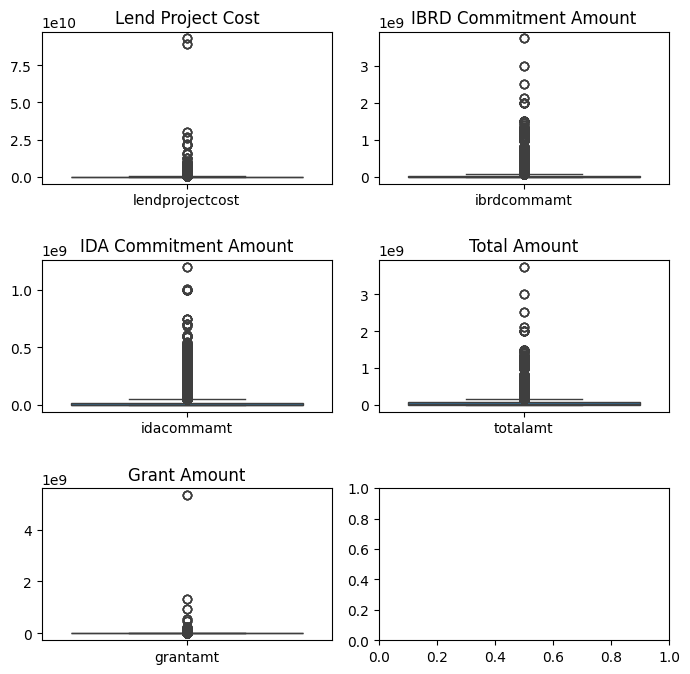

In [492]:
fig, axs = plt.subplots(3, 2, figsize=(7, 7))

# lendprojectcost
sns.boxplot(df5['lendprojectcost'], ax=axs[0, 0])
axs[0, 0].set_title("Lend Project Cost")

# ibrdcommamt
sns.boxplot(df5['ibrdcommamt'], ax=axs[0, 1])
axs[0, 1].set_title("IBRD Commitment Amount")

# idacommamt
sns.boxplot(df5['idacommamt'], ax=axs[1, 0])
axs[1, 0].set_title("IDA Commitment Amount")

# totalamt
sns.boxplot(df5['totalamt'], ax=axs[1, 1])
axs[1, 1].set_title("Total Amount")

# grantamt
sns.boxplot(df5['grantamt'], ax=axs[2, 0])
axs[2, 0].set_title("Grant Amount")

plt.tight_layout() 
plt.show()


In [493]:
df5 = df5.drop_duplicates()
df5 = df5.loc[:,~df5.columns.duplicated()]

df5 = remove_outliers_iqr(df5, 'lendprojectcost')
df5 = remove_outliers_iqr(df5, 'ibrdcommamt')
df5 = remove_outliers_iqr(df5, 'idacommamt')
df5 = remove_outliers_iqr(df5, 'totalamt')
df5 = remove_outliers_iqr(df5, 'grantamt')

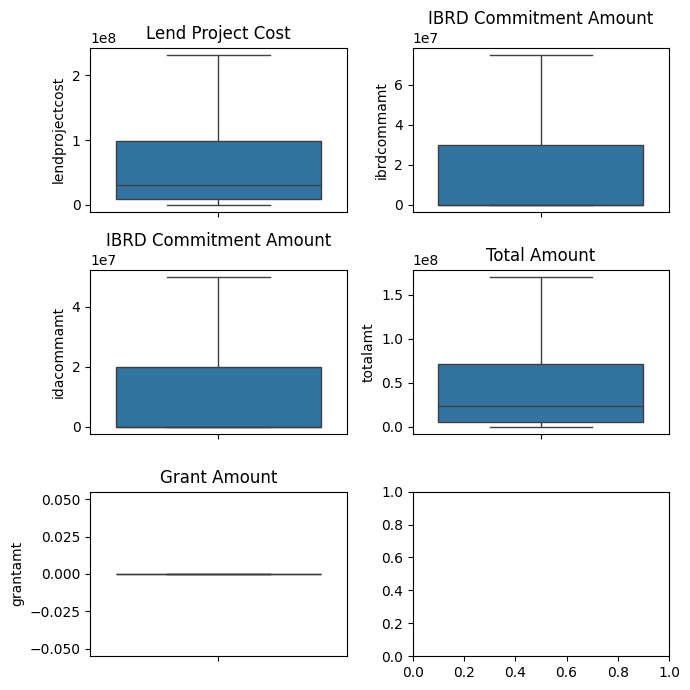

In [494]:
fig, axs = plt.subplots(3, 2, figsize=(7, 7))

# lendprojectcost
sns.boxplot(df5['lendprojectcost'], ax=axs[0, 0])
axs[0, 0].set_title("Lend Project Cost")

# ibrdcommamt
sns.boxplot(df5['ibrdcommamt'], ax=axs[0, 1])
axs[0, 1].set_title("IBRD Commitment Amount")

# idacommamt
sns.boxplot(df5['idacommamt'], ax=axs[1, 0])
axs[1, 0].set_title("IBRD Commitment Amount")

# totalamt
sns.boxplot(df5['totalamt'], ax=axs[1, 1])
axs[1, 1].set_title("Total Amount")

# grantamt
sns.boxplot(df5['grantamt'], ax=axs[2, 0])
axs[2, 0].set_title("Grant Amount")

plt.tight_layout() 
plt.show()


### 2.8 Feature Scaling

In [495]:
scaler = StandardScaler()

##### projects_data.csv

In [496]:
df5[['lendprojectcost', 
     'ibrdcommamt', 
     'idacommamt', 
     'totalamt', 
     'grantamt']] = scaler.fit_transform(df5[['lendprojectcost', 
                                              'ibrdcommamt', 
                                              'idacommamt', 
                                              'totalamt', 
                                              'grantamt']])

In [497]:
df5

,id,regionname,countryname,lendinginstr,status,project_name,boardapprovaldate,board_approval_month,closingdate,lendprojectcost,...,envassesmentcategorycode_D,envassesmentcategorycode_F,envassesmentcategorycode_U,supplementprojectflg_N,supplementprojectflg_Y,productlinetype_L,projectstatusdisplay_Active,projectstatusdisplay_Closed,projectstatusdisplay_Dropped,projectstatusdisplay_Pipeline
0,P162228,Other,World,Investment Project Financing,Active,Creating a Trade in Value-Added Database for ...,2018-06-28,June,NaT,-0.846426,...,False,False,False,True,False,True,True,False,False,False
1,P163962,Africa,Democratic Republic of the Congo,Investment Project Financing,Active,Productive Inclusion Project,2018-06-28,June,2023-12-31,1.762017,...,False,False,False,True,False,True,True,False,False,False
2,P167672,South Asia,People's Republic of Bangladesh,Investment Project Financing,Active,Additional Financing for Health Sector Support...,2018-06-28,June,NaT,-0.199218,...,False,False,False,False,True,True,True,False,False,False
3,P158768,South Asia,Islamic Republic of Afghanistan,Investment Project Financing,Active,Public-Private Partnerships and Public Investm...,2018-06-27,June,2023-06-28,-0.199218,...,False,False,False,True,False,True,True,False,False,False
4,P161364,Africa,Federal Republic of Nigeria,Investment Project Financing,Active,Nigeria For Women Project,2018-06-27,June,2023-05-31,0.454527,...,False,False,False,True,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,P006578,Latin America and Caribbean,Republic of Chile,Specific Investment Loan,Closed,Power and Irrigation Project,1948-03-25,March,1954-12-31,-0.676452,...,False,False,False,True,False,True,False,True,False,False
18244,P037451,Europe and Central Asia,Grand Duchy of Luxembourg,Structural Adjustment Loan,Closed,Steel Mill and Railway Project,1947-08-28,August,1949-03-31,-0.696064,...,False,False,False,True,False,True,False,True,False,False
18245,P037362,Europe and Central Asia,Kingdom of Denmark,Structural Adjustment Loan,Closed,Post War Reconstruction Project,1947-08-22,August,1949-03-31,-0.329967,...,False,False,False,True,False,True,False,True,False,False
18246,P037452,Europe and Central Asia,Kingdom of the Netherlands,Structural Adjustment Loan,Closed,Post-war Reconstruction Project,1947-08-07,August,1948-06-30,1.696643,...,False,False,False,True,False,True,False,True,False,False


##### Population_data

In [498]:
population_df['Value'] = scaler.fit_transform(population_df['Value'].values.reshape(-1, 1))

In [499]:
population_df

,Country Code,Country Name,Indicator Code,Indicator Name,Value,Year
0,ABW,Aruba,SP.POP.TOTL,Population Total,-0.302695,1960
167,MYS,Malaysia,SP.POP.TOTL,Population Total,-0.291250,1960
168,NAC,North America,SP.POP.TOTL,Population Total,-0.022239,1960
169,NAM,Namibia,SP.POP.TOTL,Population Total,-0.301920,1960
170,NCL,New Caledonia,SP.POP.TOTL,Population Total,-0.302660,1960
...,...,...,...,...,...,...
795,LBN,Lebanon,SP.POP.TOTL,Population Total,-0.295018,2022
105,IDA,IDA total,SP.POP.TOTL,Population Total,2.296204,2022
790,LVA,Latvia,SP.POP.TOTL,Population Total,-0.300117,2022
780,KGZ,Kyrgyz Republic,SP.POP.TOTL,Population Total,-0.292920,2022


##### gdp_data.csv

In [500]:
gdp_df

,Country Name,Country Code,Indicator Name,Indicator Code,Year,GDP
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,1960,0.000000e+00
167,Malaysia,MYS,GDP (current US$),NY.GDP.MKTP.CD,1960,1.916242e+09
168,North America,NAC,GDP (current US$),NY.GDP.MKTP.CD,1960,5.844779e+11
169,Namibia,NAM,GDP (current US$),NY.GDP.MKTP.CD,1960,0.000000e+00
170,New Caledonia,NCL,GDP (current US$),NY.GDP.MKTP.CD,1960,0.000000e+00
...,...,...,...,...,...,...
16107,Lebanon,LBN,GDP (current US$),NY.GDP.MKTP.CD,2022,0.000000e+00
15417,IDA total,IDA,GDP (current US$),NY.GDP.MKTP.CD,2022,2.822822e+12
16102,Latvia,LVA,GDP (current US$),NY.GDP.MKTP.CD,2022,4.093203e+10
16092,Kyrgyz Republic,KGZ,GDP (current US$),NY.GDP.MKTP.CD,2022,1.154397e+10


In [501]:
gdp_df['GDP'] = scaler.fit_transform(gdp_df['GDP'].values.reshape(-1, 1))

In [502]:
gdp_df

,Country Name,Country Code,Indicator Name,Indicator Code,Year,GDP
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,1960,-0.197079
167,Malaysia,MYS,GDP (current US$),NY.GDP.MKTP.CD,1960,-0.196685
168,North America,NAC,GDP (current US$),NY.GDP.MKTP.CD,1960,-0.076950
169,Namibia,NAM,GDP (current US$),NY.GDP.MKTP.CD,1960,-0.197079
170,New Caledonia,NCL,GDP (current US$),NY.GDP.MKTP.CD,1960,-0.197079
...,...,...,...,...,...,...
16107,Lebanon,LBN,GDP (current US$),NY.GDP.MKTP.CD,2022,-0.197079
15417,IDA total,IDA,GDP (current US$),NY.GDP.MKTP.CD,2022,0.383101
16102,Latvia,LVA,GDP (current US$),NY.GDP.MKTP.CD,2022,-0.188666
16092,Kyrgyz Republic,KGZ,GDP (current US$),NY.GDP.MKTP.CD,2022,-0.194706


### 2.9 Feature Engineering

#### Menggabungkan kolom countryname, countrycode, year, gdp, population, gdppercapita, ruralpopulationpercent, electricityaccesspercent, dan projectcost

###### kolom countryname, countrycode, year, serta population bisa didapat dari population_df

In [503]:
result = pd.DataFrame({})
result = pd.concat([result, population_df[['Country Name',
                                           'Country Code',
                                           'Year', 
                                           'Value']]],axis=1)

result = result.rename(columns={'Value': 'Population'})
result['Year'] = result['Year'].astype(int)
result

,Country Name,Country Code,Year,Population
0,Aruba,ABW,1960,-0.302695
167,Malaysia,MYS,1960,-0.291250
168,North America,NAC,1960,-0.022239
169,Namibia,NAM,1960,-0.301920
170,New Caledonia,NCL,1960,-0.302660
...,...,...,...,...
795,Lebanon,LBN,2022,-0.295018
105,IDA total,IDA,2022,2.296204
790,Latvia,LVA,2022,-0.300117
780,Kyrgyz Republic,KGZ,2022,-0.292920


###### kolom gdp bisa didapat dari gdp_data.csv

In [504]:
result

,Country Name,Country Code,Year,Population
0,Aruba,ABW,1960,-0.302695
167,Malaysia,MYS,1960,-0.291250
168,North America,NAC,1960,-0.022239
169,Namibia,NAM,1960,-0.301920
170,New Caledonia,NCL,1960,-0.302660
...,...,...,...,...
795,Lebanon,LBN,2022,-0.295018
105,IDA total,IDA,2022,2.296204
790,Latvia,LVA,2022,-0.300117
780,Kyrgyz Republic,KGZ,2022,-0.292920


In [505]:
result = pd.merge(result, gdp_df, on=['Country Name', 'Country Code', 'Year'], how='left')
result = result.drop(['Indicator Name', 'Indicator Code'], axis=1)

result

,Country Name,Country Code,Year,Population,GDP
0,Aruba,ABW,1960,-0.302695,-0.197079
1,Malaysia,MYS,1960,-0.291250,-0.196685
2,North America,NAC,1960,-0.022239,-0.076950
3,Namibia,NAM,1960,-0.301920,-0.197079
4,New Caledonia,NCL,1960,-0.302660,-0.197079
...,...,...,...,...,...
16637,Lebanon,LBN,2022,-0.295018,-0.197079
16638,IDA total,IDA,2022,2.296204,0.383101
16639,Latvia,LVA,2022,-0.300117,-0.188666
16640,Kyrgyz Republic,KGZ,2022,-0.292920,-0.194706


###### Kolom gdppercapita bisa didapat dari membagi antara gdp/population

In [506]:
result

,Country Name,Country Code,Year,Population,GDP
0,Aruba,ABW,1960,-0.302695,-0.197079
1,Malaysia,MYS,1960,-0.291250,-0.196685
2,North America,NAC,1960,-0.022239,-0.076950
3,Namibia,NAM,1960,-0.301920,-0.197079
4,New Caledonia,NCL,1960,-0.302660,-0.197079
...,...,...,...,...,...
16637,Lebanon,LBN,2022,-0.295018,-0.197079
16638,IDA total,IDA,2022,2.296204,0.383101
16639,Latvia,LVA,2022,-0.300117,-0.188666
16640,Kyrgyz Republic,KGZ,2022,-0.292920,-0.194706


In [507]:
result['gdppercapita'] = (result['GDP']/result['Population'])
result

,Country Name,Country Code,Year,Population,GDP,gdppercapita
0,Aruba,ABW,1960,-0.302695,-0.197079,0.651081
1,Malaysia,MYS,1960,-0.291250,-0.196685,0.675312
2,North America,NAC,1960,-0.022239,-0.076950,3.460192
3,Namibia,NAM,1960,-0.301920,-0.197079,0.652751
4,New Caledonia,NCL,1960,-0.302660,-0.197079,0.651157
...,...,...,...,...,...,...
16637,Lebanon,LBN,2022,-0.295018,-0.197079,0.668024
16638,IDA total,IDA,2022,2.296204,0.383101,0.166841
16639,Latvia,LVA,2022,-0.300117,-0.188666,0.628642
16640,Kyrgyz Republic,KGZ,2022,-0.292920,-0.194706,0.664708


###### Kolom ruralpopulationpercent dan electricityaccesspercent bisa didapat dari data hasil combine ruralpopulation dan electricityaccess

In [508]:
combined

,Country Name,Country Code,Indicator Name_x,Indicator Code_x,Year,electricityaccesspercent,Indicator Name_y,Indicator Code_y,ruralpopulationpercent
0,Aruba,ABW,Access to electricity (% of population),EG.ELC.ACCS.ZS,1960,0.0,Rural population (% of total population),SP.RUR.TOTL.ZS,49.224000
1,Malaysia,MYS,Access to electricity (% of population),EG.ELC.ACCS.ZS,1960,0.0,Rural population (% of total population),SP.RUR.TOTL.ZS,73.402000
2,North America,NAC,Access to electricity (% of population),EG.ELC.ACCS.ZS,1960,0.0,Rural population (% of total population),SP.RUR.TOTL.ZS,30.081597
3,Namibia,NAM,Access to electricity (% of population),EG.ELC.ACCS.ZS,1960,0.0,Rural population (% of total population),SP.RUR.TOTL.ZS,82.091000
4,New Caledonia,NCL,Access to electricity (% of population),EG.ELC.ACCS.ZS,1960,0.0,Rural population (% of total population),SP.RUR.TOTL.ZS,62.640000
...,...,...,...,...,...,...,...,...,...
16903,Liberia,LBR,Access to electricity (% of population),EG.ELC.ACCS.ZS,2023,0.0,Rural population (% of total population),SP.RUR.TOTL.ZS,0.000000
16904,Lesotho,LSO,Access to electricity (% of population),EG.ELC.ACCS.ZS,2023,0.0,Rural population (% of total population),SP.RUR.TOTL.ZS,0.000000
16905,Lebanon,LBN,Access to electricity (% of population),EG.ELC.ACCS.ZS,2023,0.0,Rural population (% of total population),SP.RUR.TOTL.ZS,0.000000
16906,Malawi,MWI,Access to electricity (% of population),EG.ELC.ACCS.ZS,2023,0.0,Rural population (% of total population),SP.RUR.TOTL.ZS,0.000000


In [509]:
result = pd.merge(result, combined, on=['Country Name', 'Country Code', 'Year'], how='left')
result = result.drop(['Indicator Name_x', 'Indicator Name_y', 'Indicator Code_x', 'Indicator Code_y'], axis=1)

result

,Country Name,Country Code,Year,Population,GDP,gdppercapita,electricityaccesspercent,ruralpopulationpercent
0,Aruba,ABW,1960,-0.302695,-0.197079,0.651081,0.0,49.224000
1,Malaysia,MYS,1960,-0.291250,-0.196685,0.675312,0.0,73.402000
2,North America,NAC,1960,-0.022239,-0.076950,3.460192,0.0,30.081597
3,Namibia,NAM,1960,-0.301920,-0.197079,0.652751,0.0,82.091000
4,New Caledonia,NCL,1960,-0.302660,-0.197079,0.651157,0.0,62.640000
...,...,...,...,...,...,...,...,...
16637,Lebanon,LBN,2022,-0.295018,-0.197079,0.668024,0.0,10.738000
16638,IDA total,IDA,2022,2.296204,0.383101,0.166841,0.0,61.142149
16639,Latvia,LVA,2022,-0.300117,-0.188666,0.628642,0.0,31.460000
16640,Kyrgyz Republic,KGZ,2022,-0.292920,-0.194706,0.664708,0.0,62.539000


###### Kolom project cost didapat dari projects_data.csv

In [510]:
# Sum Column lendprojectcost berdasarkan nama negara
df_sum = df5.groupby('countryname')['lendprojectcost'].sum().reset_index()
df_sum.columns = ['Long Country Name', 'projectcost']

In [511]:
print(df_sum)

               Long Country Name  projectcost
0                         Africa   -85.557457
1                 American Samoa    -0.850348
2               Andean Countries    -2.533742
3            Antigua and Barbuda    -0.722214
4         Arab Republic of Egypt    91.984493
..                           ...          ...
201  United Republic of Tanzania     9.888361
202           West Bank and Gaza   -62.443249
203               Western Africa    32.000904
204              Western Balkans    -4.481074
205                        World   -78.554664

[206 rows x 2 columns]


In [512]:
df_sum['Long Country Name'].to_list()

['Africa',
 'American Samoa',
 'Andean Countries',
 'Antigua and Barbuda',
 'Arab Republic of Egypt',
 'Aral Sea',
 'Argentine Republic',
 'Asia',
 'Barbados',
 'Belize',
 'Bosnia and Herzegovina',
 'Burkina Faso',
 'Caribbean',
 'Caucasus',
 'Central Africa',
 'Central African Republic',
 'Central America',
 'Central Asia',
 'Co-operative Republic of Guyana',
 'Commonwealth of Australia',
 'Commonwealth of Dominica',
 'Commonwealth of The Bahamas',
 'Czech Republic',
 'Democratic Republic of Sao Tome and Prin',
 'Democratic Republic of Timor-Leste',
 'Democratic Republic of the Congo',
 'Democratic Socialist Republic of Sri Lan',
 'Dominican Republic',
 'EU Accession Countries',
 'East Asia and Pacific',
 'Eastern Africa',
 'Europe and Central Asia',
 'Federal Democratic Republic of Ethiopia',
 'Federal Republic of Nigeria',
 'Federated States of Micronesia',
 'Federative Republic of Brazil',
 'French Republic',
 'Gabonese Republic',
 'Georgia',
 'Grand Duchy of Luxembourg',
 'Grenada

In [513]:
df_sum['shortname'] = df_sum['Long Country Name'].apply(lambda x: x.split()[-1])

In [515]:
result

,Country Name,Country Code,Year,Population,GDP,gdppercapita,electricityaccesspercent,ruralpopulationpercent
0,Aruba,ABW,1960,-0.302695,-0.197079,0.651081,0.0,49.224000
1,Malaysia,MYS,1960,-0.291250,-0.196685,0.675312,0.0,73.402000
2,North America,NAC,1960,-0.022239,-0.076950,3.460192,0.0,30.081597
3,Namibia,NAM,1960,-0.301920,-0.197079,0.652751,0.0,82.091000
4,New Caledonia,NCL,1960,-0.302660,-0.197079,0.651157,0.0,62.640000
...,...,...,...,...,...,...,...,...
16637,Lebanon,LBN,2022,-0.295018,-0.197079,0.668024,0.0,10.738000
16638,IDA total,IDA,2022,2.296204,0.383101,0.166841,0.0,61.142149
16639,Latvia,LVA,2022,-0.300117,-0.188666,0.628642,0.0,31.460000
16640,Kyrgyz Republic,KGZ,2022,-0.292920,-0.194706,0.664708,0.0,62.539000


In [516]:
result = pd.merge(result, df_sum, left_on=['Country Name'], right_on=['shortname'], how='left')
result = result.drop(['shortname'], axis=1)
result = result[['Country Name',
                 'Long Country Name',
                 'Country Code',
                 'Year',
                 'Population',
                 'GDP',
                 'gdppercapita',
                 'electricityaccesspercent',
                 'ruralpopulationpercent',
                 'projectcost']]
result

,Country Name,Long Country Name,Country Code,Year,Population,GDP,gdppercapita,electricityaccesspercent,ruralpopulationpercent,projectcost
0,Aruba,NaN,ABW,1960,-0.302695,-0.197079,0.651081,0.0,49.224000,NaN
1,Malaysia,Malaysia,MYS,1960,-0.291250,-0.196685,0.675312,0.0,73.402000,-13.784959
2,North America,NaN,NAC,1960,-0.022239,-0.076950,3.460192,0.0,30.081597,NaN
3,Namibia,Republic of Namibia,NAM,1960,-0.301920,-0.197079,0.652751,0.0,82.091000,-5.172039
4,New Caledonia,NaN,NCL,1960,-0.302660,-0.197079,0.651157,0.0,62.640000,NaN
...,...,...,...,...,...,...,...,...,...,...
16889,Lebanon,NaN,LBN,2022,-0.295018,-0.197079,0.668024,0.0,10.738000,NaN
16890,IDA total,NaN,IDA,2022,2.296204,0.383101,0.166841,0.0,61.142149,NaN
16891,Latvia,Republic of Latvia,LVA,2022,-0.300117,-0.188666,0.628642,0.0,31.460000,-6.483496
16892,Kyrgyz Republic,NaN,KGZ,2022,-0.292920,-0.194706,0.664708,0.0,62.539000,NaN


In [517]:
print(result.dtypes)

Country Name                 object
Long Country Name            object
Country Code                 object
Year                          int32
Population                  float64
GDP                         float64
gdppercapita                float64
electricityaccesspercent    float64
ruralpopulationpercent      float64
projectcost                 float64
dtype: object


In [518]:
ab = result[result['Country Name'] == 'Afghanistan']
ab

,Country Name,Long Country Name,Country Code,Year,Population,GDP,gdppercapita,electricityaccesspercent,ruralpopulationpercent,projectcost
202,Afghanistan,Islamic Republic of Afghanistan,AFG,1960,-0.290065,-0.196968,0.679049,0.000000,91.779,-35.353625
437,Afghanistan,Islamic Republic of Afghanistan,AFG,1961,-0.289824,-0.196966,0.679605,0.000000,91.492,-35.353625
708,Afghanistan,Islamic Republic of Afghanistan,AFG,1962,-0.289571,-0.196966,0.680200,0.000000,91.195,-35.353625
974,Afghanistan,Islamic Republic of Afghanistan,AFG,1963,-0.289306,-0.196924,0.680679,0.000000,90.890,-35.353625
1243,Afghanistan,Islamic Republic of Afghanistan,AFG,1964,-0.289027,-0.196914,0.681301,0.000000,90.574,-35.353625
...,...,...,...,...,...,...,...,...,...,...
15619,Afghanistan,Islamic Republic of Afghanistan,AFG,2018,-0.250956,-0.193368,0.770528,93.430878,74.505,-35.353625
15996,Afghanistan,Islamic Republic of Afghanistan,AFG,2019,-0.249426,-0.193215,0.774637,97.700000,74.246,-35.353625
16299,Afghanistan,Islamic Republic of Afghanistan,AFG,2020,-0.247728,-0.192977,0.778989,97.700000,73.974,-35.353625
16427,Afghanistan,Islamic Republic of Afghanistan,AFG,2021,-0.246136,-0.194147,0.788779,97.700000,73.686,-35.353625


In [581]:
result = result.fillna(0)

,Country Name,Long Country Name,Country Code,Year,Population,GDP,gdppercapita,electricityaccesspercent,ruralpopulationpercent,projectcost
0,Aruba,Malaysia,ABW,1960,-0.302695,-0.197079,0.651081,0.0,49.224000,-13.784959
1,Malaysia,Malaysia,MYS,1960,-0.291250,-0.196685,0.675312,0.0,73.402000,-13.784959
2,North America,Malaysia,NAC,1960,-0.022239,-0.076950,3.460192,0.0,30.081597,-13.784959
3,Namibia,Republic of Namibia,NAM,1960,-0.301920,-0.197079,0.652751,0.0,82.091000,-5.172039
4,New Caledonia,Republic of Namibia,NCL,1960,-0.302660,-0.197079,0.651157,0.0,62.640000,-5.172039
...,...,...,...,...,...,...,...,...,...,...
16889,Lebanon,Kingdom of Lesotho,LBN,2022,-0.295018,-0.197079,0.668024,0.0,10.738000,-36.672050
16890,IDA total,Kingdom of Lesotho,IDA,2022,2.296204,0.383101,0.166841,0.0,61.142149,-36.672050
16891,Latvia,Republic of Latvia,LVA,2022,-0.300117,-0.188666,0.628642,0.0,31.460000,-6.483496
16892,Kyrgyz Republic,Republic of Latvia,KGZ,2022,-0.292920,-0.194706,0.664708,0.0,62.539000,-6.483496


### 3. Load Data

In [519]:
result.to_csv('result/result.csv')

In [520]:
# url: str = os.environ.get("SUPABASE_URL")
# key: str = os.environ.get("SUPABASE_KEY")
# supabase = create_client(url, key)

# with open("result/result.csv", "rb") as f:
#     supabase.storage.from_("mini_project_de").upload(
#         file=f,
#         path="result.csv",
#     )

In [619]:
DB_HOST = os.environ.get("DB_HOST")
DB_USER = os.environ.get("DB_USER")
DB_PASSWORD = os.environ.get("DB_PASSWORD")
DB_NAME = os.environ.get("DB_NAME")

print(DB_HOST)
print(DB_USER)
print(DB_PASSWORD)
print(DB_NAME)

localhost
root
@25Raihan
mini-project-de


In [640]:
DB_HOST = "localhost"
DB_USER = "root"
DB_PASSWORD = "@25Raihan"
DB_NAME = "mini-project-de"

connection = pymysql.connect(
    host=DB_HOST,
    user=DB_USER,
    password=DB_PASSWORD,
    db=DB_NAME
)

def create_tables():
    with connection.cursor() as cursor:
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS country_data (
                id INT AUTO_INCREMENT PRIMARY KEY,
                Country_Name VARCHAR(255),
                Long_Country_Name VARCHAR(255),
                Country_Code CHAR(3),
                Year INT(4),
                Population INT(255),
                GDP INT(255),
                gdppercapita INT(255),
                electricityaccesspercent INT(255),
                ruralpopulationpercent INT(255),
                projectcost INT(255)
            )
        """)
    connection.commit()

def insert_from_csv(csv_file):
    with open(csv_file, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        with connection.cursor() as cursor:
            for row in reader:

                for key, value in row.items():
                    if pd.isnull(value):
                        row[key] = '-'
                        
                country_name = row['Country Name']
                long_CN = row['Long Country Name']
                country_code = row['Country Code']
                year = int(row['Year'])
                population = float(row['Population'])
                gdp = float(row['GDP'])
                capita = float(row['gdppercapita'])
                access = float(row['electricityaccesspercent'])
                rurals = float(row['ruralpopulationpercent'])
                cost = float(row['projectcost'])

                cursor.execute(f"""
                               INSERT INTO country_data (
                                Country_Name,
                                Long_Country_Name,
                                Country_Code,
                                Year,
                                Population,
                                GDP,
                                gdppercapita,
                                electricityaccesspercent,
                                ruralpopulationpercent,
                                projectcost
                               ) VALUES (
                               {country_name},
                               {long_CN},
                               {country_code},
                               {year},
                               {population},
                               {gdp},
                               {capita},
                               {access},
                               {rurals},
                               {cost}
                               )
                            """)
            connection.commit()

create_tables()
insert_from_csv('result/result.csv')


ValueError: could not convert string to float: ''

### 4. Data Visualization

##### Korelasi Antar Kolom-Kolom Yang Memuat Nilai Nilai Cost didalam project_data

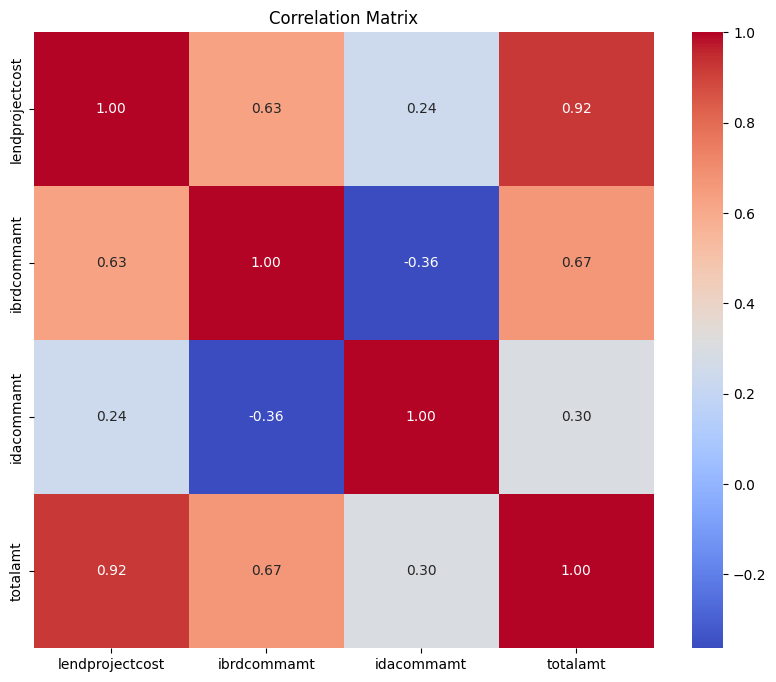

In [616]:
# Mengambil hanya kolom-kolom numerik
numeric_columns = df5[['lendprojectcost', 'ibrdcommamt', 'idacommamt', 'totalamt']]

# Menghitung korelasi antara variabel numerik
correlation_matrix = numeric_columns.corr()

# Visualisasi heatmap korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


##### Distribusi jumlah proyek berdasarkan status

<Figure size 800x600 with 0 Axes>

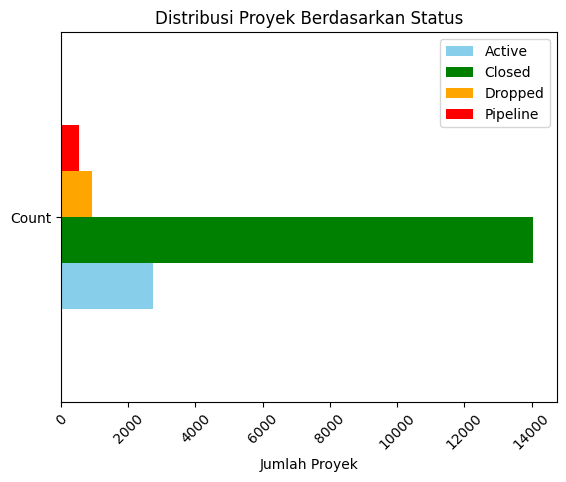

In [522]:
active_project = df5[df5['projectstatusdisplay_Active'] == True].shape[0]
closed_project = df5[df5['projectstatusdisplay_Closed'] == True].shape[0]
dropped_project = df5[df5['projectstatusdisplay_Dropped'] == True].shape[0]
pipeline_project = df5[df5['projectstatusdisplay_Pipeline'] == True].shape[0]

status_counts = pd.DataFrame({
    'Active': active_project,
    'Closed': closed_project,
    'Dropped': dropped_project,
    'Pipeline': pipeline_project
}, index=['Count'])

plt.figure(figsize=(8, 6))
status_counts.plot(kind='barh', color=['skyblue', 'green', 'orange', 'red'])
plt.title('Distribusi Proyek Berdasarkan Status')
plt.xlabel('Jumlah Proyek')
plt.xticks(rotation=45)
plt.show()

##### Perbandingan antara proyek yang ditutup dan aktif

In [523]:
closed = df5[df5['projectstatusdisplay_Closed'] == True]
closed_sorted = closed['regionname'].value_counts().head(10)
closed_sorted

regionname
Africa                          4277
Latin America and Caribbean     2739
East Asia and Pacific           2245
Europe and Central Asia         1900
South Asia                      1619
Middle East and North Africa    1206
Other                             69
Name: count, dtype: int64

In [524]:
active = df5[df5['projectstatusdisplay_Active'] == True]
active_sorted = active['regionname'].value_counts().head(10)
active_sorted

regionname
Africa                          1020
East Asia and Pacific            447
South Asia                       385
Europe and Central Asia          347
Latin America and Caribbean      325
Middle East and North Africa     175
Other                             26
Name: count, dtype: int64

<Figure size 1200x600 with 0 Axes>

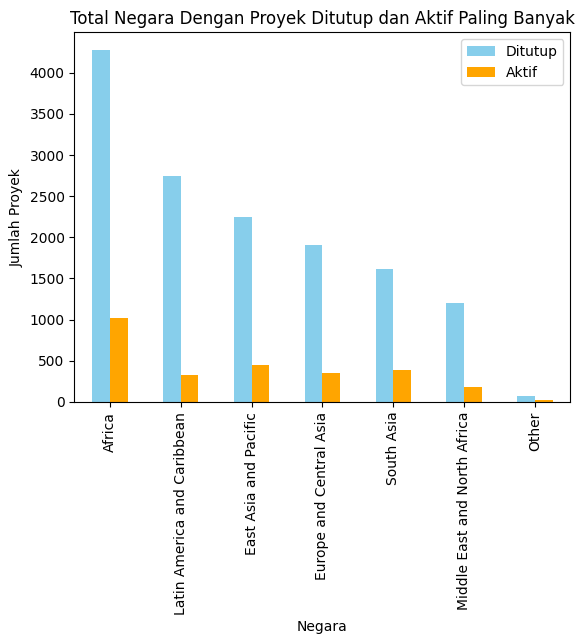

In [551]:
combined_df = pd.concat([closed_sorted, active_sorted], axis=1, keys=['Closed', 'Active'])

plt.figure(figsize=(12, 6))

combined_df.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Total Negara Dengan Proyek Ditutup dan Aktif Paling Banyak')
plt.xlabel('Negara')
plt.ylabel('Jumlah Proyek')
plt.legend(['Ditutup', 'Aktif'])
plt.show()

##### Perbandingan populasi antara Negara Indonesia dengan Negara-negara Asean

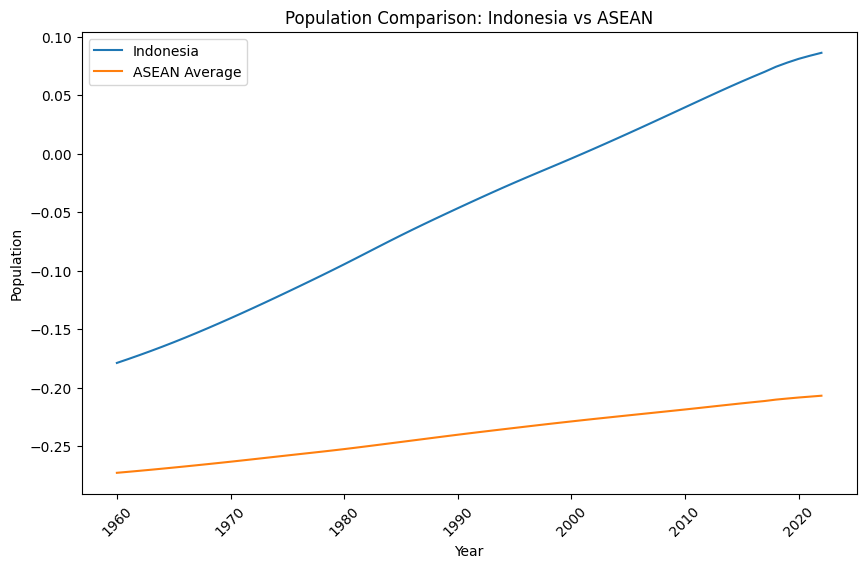

In [554]:
asean_countries = ['IDN', 'SGP', 'THA', 'PHL', 'MYS', 'VNM', 'MMR', 'KHM', 'LAO', 'BRN']

indonesia_data = result[result['Country Code'] == 'IDN']
asean_data = result[result['Country Code'].isin(asean_countries)]

plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Population', data=indonesia_data, label='Indonesia')
sns.lineplot(x='Year', y='Population', data=asean_data, estimator='mean', errorbar=None, label='ASEAN Average')
plt.title('Population Comparison: Indonesia vs ASEAN')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.xticks(rotation=45)
plt.show()

##### Perbandingan GDP Antara Negara Indonesia dan Negara-Negara ASEAN

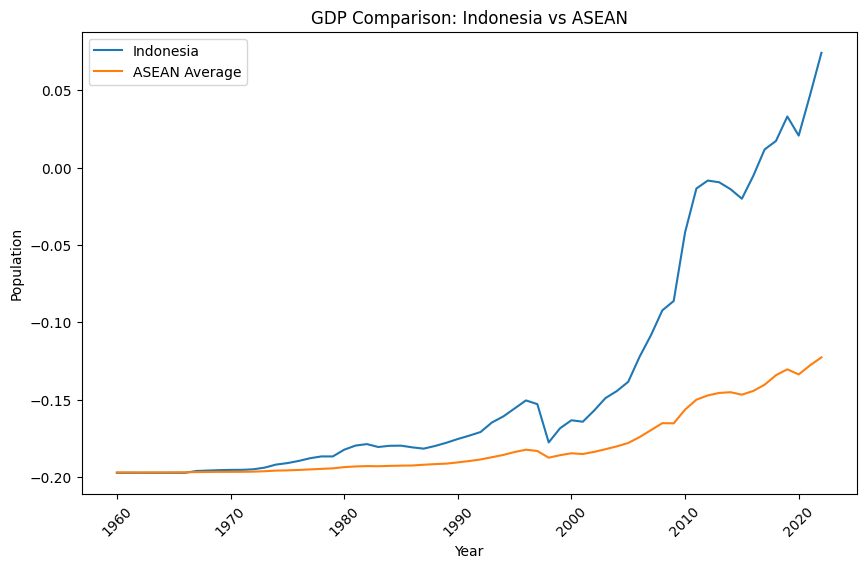

In [585]:
asean_countries = ['IDN', 'SGP', 'THA', 'PHL', 'MYS', 'VNM', 'MMR', 'KHM', 'LAO', 'BRN']

indonesia_data = result[result['Country Code'] == 'IDN']
asean_data = result[result['Country Code'].isin(asean_countries)]

plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='GDP', data=indonesia_data, label='Indonesia')
sns.lineplot(x='Year', y='GDP', data=asean_data, estimator='mean', errorbar=None, label='ASEAN Average')
plt.title('GDP Comparison: Indonesia vs ASEAN')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.xticks(rotation=45)
plt.show()

##### Korelasi Data-Data Numerik dari data result

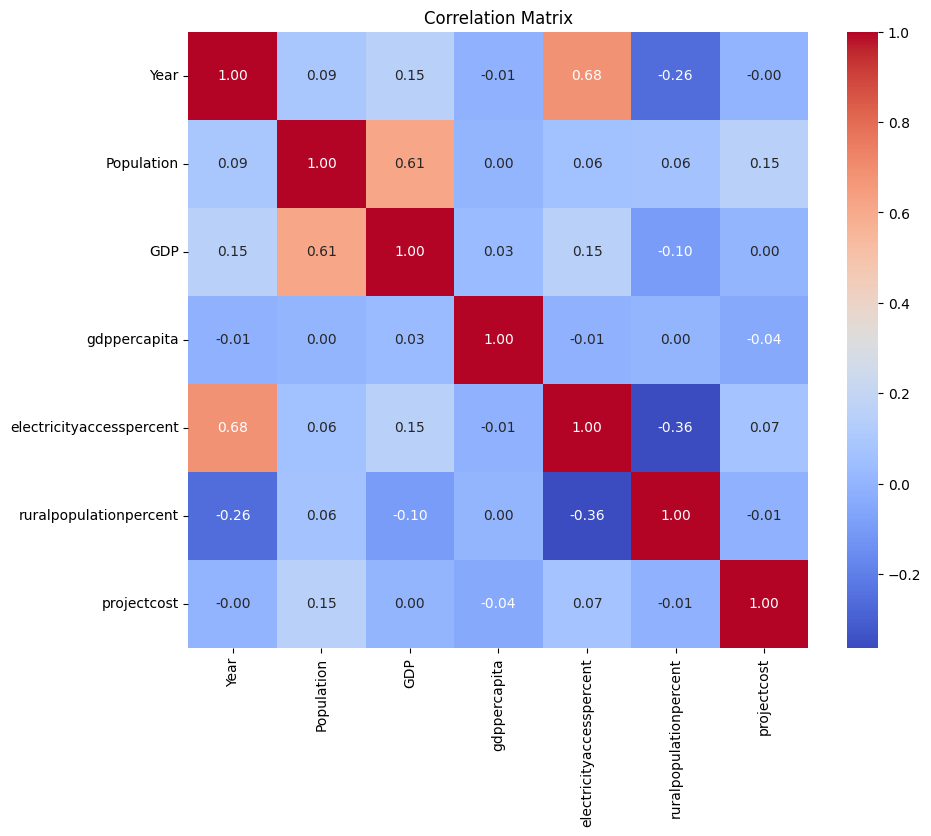

In [620]:
# Mengambil hanya kolom-kolom numerik
numeric_columns = result.select_dtypes(include=[np.number])

# Menghitung korelasi antara variabel numerik
correlation_matrix = numeric_columns.corr()

# Visualisasi heatmap korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


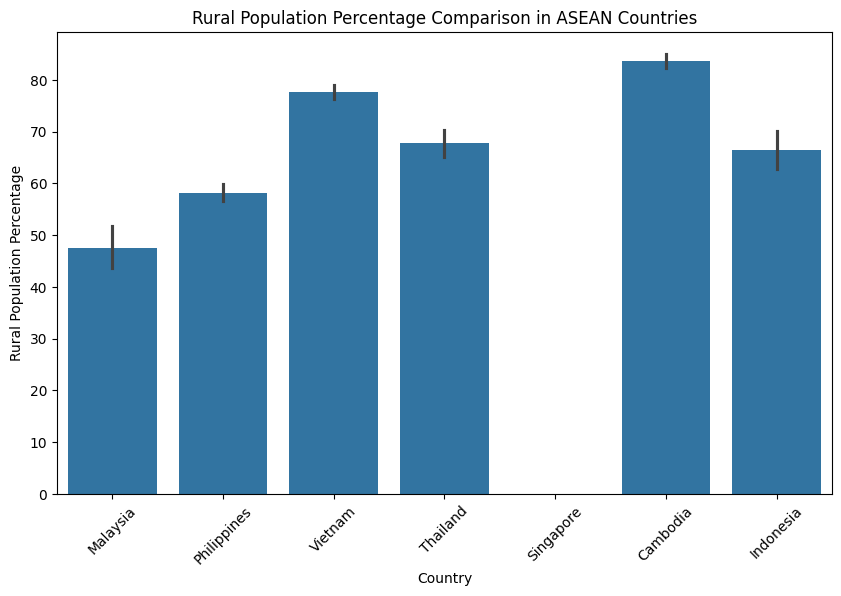

In [631]:
# 1. Identifikasi negara-negara ASEAN dalam dataset
asean_countries = ['Indonesia', 'Malaysia', 'Singapore', 'Thailand', 'Philippines', 'Vietnam', 'Brunei', 'Laos', 'Cambodia']

# 2. Filter data untuk hanya mempertahankan baris yang terkait dengan negara-negara ASEAN
asean_df = result[result['Country Name'].isin(asean_countries)]

# 3. Visualisasi perbandingan populasi pedesaan
plt.figure(figsize=(10, 6))
sns.barplot(x='Country Name', y='ruralpopulationpercent', data=asean_df)
plt.title('Rural Population Percentage Comparison in ASEAN Countries')
plt.xlabel('Country')
plt.ylabel('Rural Population Percentage')
plt.xticks(rotation=45)
plt.show()